# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [18]:
import numpy as np
import os
from PIL import Image  # Using Pillow for image processing
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import random as rn
import tensorflow as tf

In [19]:
!df -h /home

Filesystem      Size  Used Avail Use% Mounted on
/dev/rbd5        20G  794M   20G   4% /home


In [20]:
!rm -rf ~/.local/share/Trash/*

We set the random seed so that the results don't vary drastically.

In [21]:
# Set random seeds for reproducibility
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [22]:
# File paths
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

# Set batch size (adjust based on available resources)
batch_size = 16

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [23]:
# Define the image generator
def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)
    
    img_idx = np.linspace(0, 29, 10, dtype=int)  # Selecting 10 frames out of 30
    x, y, z = 160, 160, 3  # Image dimensions
    
    while True:
        t = np.random.permutation(folder_list)  # Shuffle folder list
        num_batches = len(t) // batch_size
        
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, len(img_idx), x, y, z))  # Initialize batch data array
            batch_labels = np.zeros((batch_size, 5))  # Initialize batch labels (5 classes)

            for folder in range(batch_size):
                folder_name = t[folder + (batch * batch_size)].split(';')[0]
                folder_path = os.path.join(source_path, folder_name)
                
                # Safeguard in case of missing folder or images
                if not os.path.exists(folder_path):
                    print(f"Folder {folder_name} not found.")
                    continue
                
                imgs = os.listdir(folder_path)
                imgs.sort()  # Ensure correct order of frames
                
                for idx, item in enumerate(img_idx):
                    try:
                        img = load_img(os.path.join(folder_path, imgs[item]))
                        img = img_to_array(img)
                        img = Image.fromarray(img.astype('uint8')).resize((x, y))  # Resize to 160x160
                        img = np.array(img) / 255.0  # Normalize
                        batch_data[folder, idx, :, :, :] = img
                    except Exception as e:
                        print(f"Error processing image {imgs[item]}: {e}")
                
                # One-hot encoding of labels
                label = int(t[folder + (batch * batch_size)].strip().split(';')[2])
                batch_labels[folder, label] = 1

            yield batch_data, batch_labels  # Yield the batch

        # Handle leftover batch
        if len(t) % batch_size != 0:
            batch_data = np.zeros((len(t) % batch_size, len(img_idx), x, y, z))
            batch_labels = np.zeros((len(t) % batch_size, 5))

            for folder in range(len(t) % batch_size):
                folder_name = t[folder + (num_batches * batch_size)].split(';')[0]
                folder_path = os.path.join(source_path, folder_name)
                imgs = os.listdir(folder_path)

                for idx, item in enumerate(img_idx):
                    img = load_img(os.path.join(folder_path, imgs[item]))
                    img = img_to_array(img)
                    img = Image.fromarray(img.astype('uint8')).resize((x, y))
                    img = np.array(img) / 255.0
                    batch_data[folder, idx, :, :, :] = img

                label = int(t[folder + (num_batches * batch_size)].strip().split(';')[2])
                batch_labels[folder, label] = 1

            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [24]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [25]:
# Model architecture
model = Sequential()

# 3D Conv layers
model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=(10, 160, 160, 3), padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 1)))
model.add(BatchNormalization())

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))  # Output layer (5 classes)


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [26]:
# Compile model
optimiser = Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model summary
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 10, 160, 160, 32)  2624      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 5, 80, 80, 32)    0         
 3D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 5, 80, 80, 32)    128       
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 5, 80, 80, 64)     55360     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 2, 40, 40, 64)    0         
 3D)                                                             
                                                      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [27]:
# Train and validation generators
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [28]:
# Checkpoint and learning rate schedule
model_name = "model_init_" + str(datetime.datetime.now()).replace(' ', '_').replace(':', '_').replace('.', '_') + "/model-{epoch:03d}-{loss:.4f}-{categorical_accuracy:.4f}.h5"
if not os.path.exists(os.path.dirname(model_name)):
    os.makedirs(os.path.dirname(model_name))

checkpoint = ModelCheckpoint(filepath=model_name, monitor='categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

callbacks_list = [checkpoint, lr_reduce]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [29]:
steps_per_epoch = (len(train_doc) + batch_size - 1) // batch_size
validation_steps = (len(val_doc) + batch_size - 1) // batch_size

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [30]:
# Model fitting
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    workers=1
)

Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/50
42/42 [==============================] - ETA: 0s - loss: 18.8930 - categorical_accuracy: 0.4661Source path =  /home/datasets/Project_data/val ; batch size = 16

Epoch 00001: categorical_accuracy improved from -inf to 0.46606, saving model to model_init_2024-09-29_07_13_04_159942/model-001-18.8930-0.4661.h5
42/42 [==============================] - 32s 759ms/step - loss: 18.8930 - categorical_accuracy: 0.4661 - val_loss: 18.9044 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - ETA: 0s - loss: 8.0714 - categorical_accuracy: 0.6712
Epoch 00002: categorical_accuracy improved from 0.46606 to 0.67119, saving model to model_init_2024-09-29_07_13_04_159942/model-002-8.0714-0.6712.h5
42/42 [==============================] - 30s 731ms/step - loss: 8.0714 - categorical_accuracy: 0.6712 - val_loss: 25.6082 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/50
42/42 [

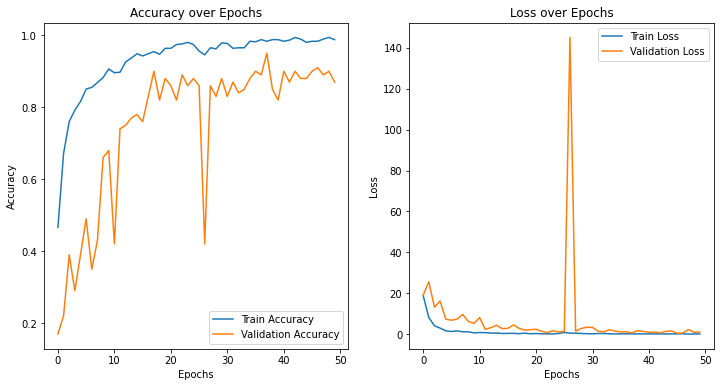


Final Model Summary:
Training Accuracy: 0.9879
Validation Accuracy: 0.8700
Training Loss: 0.0293
Validation Loss: 1.0315


In [31]:
# Plot training history
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def print_training_summary(history):
    final_train_accuracy = history.history['categorical_accuracy'][-1]
    final_val_accuracy = history.history['val_categorical_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print("\nFinal Model Summary:")
    print(f"Training Accuracy: {final_train_accuracy:.4f}")
    print(f"Validation Accuracy: {final_val_accuracy:.4f}")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")

# Plot the graphs and print the summary
plot_training_history(history)
print_training_summary(history)

In [35]:
# Save the final model
model.save('/home/dl_content/Upgrad DL/Gesture Recognition Assignment/gesture_recognition_final_model2.h5')